In [1]:
# importing required libraries
import matplotlib
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import sys
from IPython.display import display
from IPython.display import Image
import warnings
import matplotlib.pyplot as plt
import datetime
import pycountry_convert as pc
import pycountry
import folium
import joblib
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import export_graphviz
import pydot
import seaborn as sns

# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## Read in the Train and Test data

In [2]:
X_train = np.array(pd.read_parquet('../data/final/X_train.parquet')).astype('float')
X_test = np.array(pd.read_parquet('../data/final/X_test.parquet')).astype('float')

y_test_class = np.array(pd.read_parquet('../data/final/y_test.parquet')['sum_payments_package_key_ltv_class'])
y_train_class = np.array(pd.read_parquet('../data/final/y_train.parquet')['sum_payments_package_key_ltv_class'])
n_class = 3

### Extra analysis without transactional data

In [59]:
X1 = pd.read_parquet('../data/final/X_train.parquet')
X2 = pd.read_parquet('../data/final/X_test.parquet')
y1 = np.array(pd.read_parquet('../data/final/y_train.parquet')['sum_payments_package_key_ltv_class'])
y2 = np.array(pd.read_parquet('../data/final/y_test.parquet')['sum_payments_package_key_ltv_class'])

In [60]:
X1 = X1.drop(axis=0, columns=['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'])
X2 = X2.drop(axis=0, columns=['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'])
X = np.concatenate((X1, X2), axis=0).astype('float')
y = np.concatenate((y1, y2), axis=0)

In [61]:
dtc = DecisionTreeClassifier()
score = cross_val_score(estimator=dtc, X=X, y=y, cv=10)
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.77264921 0.77350794 0.76871332 0.76928582 0.77651353 0.76928582
 0.77179047 0.77057392 0.76885645 0.76977027]
The mean is 0.7710946741825622 with a standard deviation of 0.0023945385911366118


In [62]:
dtc = DecisionTreeClassifier()
score = cross_val_score(estimator=dtc, X=X, y=y, cv=10, scoring=make_scorer(cohen_kappa_score))
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.65247537 0.66208333 0.64765242 0.65440377 0.65790539 0.6506387
 0.65412627 0.65421492 0.65084036 0.65109401]
The mean is 0.6535434521338487 with a standard deviation of 0.0038868473493677896


### Classifier

In [47]:
dtc = DecisionTreeClassifier()

# Train the model on training data
dtc.fit(X_train, y_train_class)

DecisionTreeClassifier()

In [48]:
y_pred_c = dtc.predict(X_test)

In [49]:
# Model Accuracy, how often is the classifier correct?
print("Test Set Accuracy:",metrics.accuracy_score(y_test_class, y_pred_c))
print('MAE: %.3f (%.3f)' % (np.mean(y_pred_c), np.std(y_pred_c)))

Test Set Accuracy: 0.7711821955059396
MAE: 1.077 (0.770)


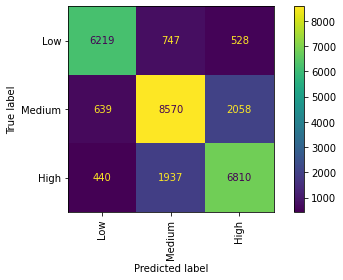

In [9]:
cm = confusion_matrix(y_test_class, y_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Medium','High'])
disp.plot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../pictures/DT_Class_Confusion.png')

#### 10 Fold Cross Validation

In [50]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_class, y_test_class), axis=0)

score = cross_val_score(estimator=dtc, X=inputs, y=targets, cv=10)
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.77493917 0.77880349 0.77773007 0.77186203 0.78166595 0.77651353
 0.77164735 0.78109346 0.77286389 0.7718457 ]
The mean is 0.7758964637591415 with a standard deviation of 0.003651611748404346


In [54]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_class, y_test_class), axis=0)

score = cross_val_score(estimator=dtc, X=inputs, y=targets, cv=10, scoring=make_scorer(cohen_kappa_score))
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.65521865 0.66236426 0.66556505 0.64894551 0.66707651 0.66137168
 0.65563421 0.66639811 0.65042271 0.6480791 ]
The mean is 0.6581075787562876 with a standard deviation of 0.0070113970279542855


# OLD
## Visualize most important features

In [54]:
feature_list = list(pd.read_parquet('../data/final/X_train.parquet').columns)

feature_imp = pd.Series(dtc.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp[:20]

sum_payments_package_key                 0.648040
total_session_duration                   0.020880
time_between_last_purchase_last_login    0.013892
clumpiness                               0.013865
n_package_info_offers_viewed             0.011306
masked_feature_8                         0.009997
masked_feature_20                        0.009316
masked_feature_25                        0.009233
masked_feature_39                        0.009128
n_package_tips_offers_viewed             0.008958
masked_feature_28                        0.008817
gdp_per_capita                           0.007853
masked_feature_37                        0.007026
n_sessions_ended                         0.007020
masked_feature_27                        0.006924
n_ads_watched                            0.006907
n_missions_completed                     0.006854
n_sessions_started                       0.006780
masked_feature_6                         0.006017
masked_feature_3                         0.005789


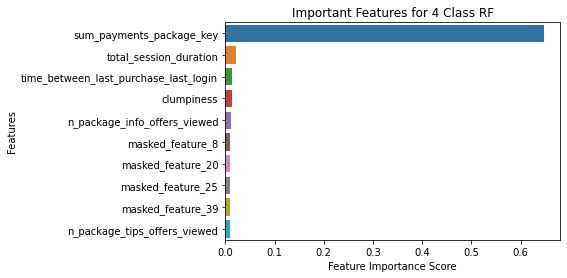

In [55]:
sns.barplot(x=feature_imp, y=feature_imp.index, order=feature_imp.iloc[:10].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for 4 Class RF")
plt.show()

# Visualization

In [48]:
# Pull out one tree from the forest
tree = dtc
# Export the image to a dot file
export_graphviz(tree, out_file = 'data/tree.dot', feature_names = feature_list, class_names = str(tree.classes_), precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('data/tree.dot')
# Write graph to a png file
graph.write_png('pictures/tree.png')
Image('pictures/tree.png')

NameError: name 'feature_list' is not defined

In [56]:
# Get numerical feature importances
importances = list(loaded_dtc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sum_payments_package_key Importance: 0.63
Variable: total_session_duration Importance: 0.02
Variable: clumpiness           Importance: 0.02
Variable: n_ads_watched        Importance: 0.01
Variable: n_battlepass_lvls_finished Importance: 0.01
Variable: masked_feature_2     Importance: 0.01
Variable: masked_feature_3     Importance: 0.01
Variable: masked_feature_6     Importance: 0.01
Variable: masked_feature_8     Importance: 0.01
Variable: masked_feature_13    Importance: 0.01
Variable: masked_feature_20    Importance: 0.01
Variable: masked_feature_23    Importance: 0.01
Variable: masked_feature_25    Importance: 0.01
Variable: masked_feature_27    Importance: 0.01
Variable: masked_feature_28    Importance: 0.01
Variable: masked_feature_35    Importance: 0.01
Variable: masked_feature_37    Importance: 0.01
Variable: n_missions_completed Importance: 0.01
Variable: n_package_info_offers_viewed Importance: 0.01
Variable: n_package_tips_offers_viewed Importance: 0.01
Variable: ma

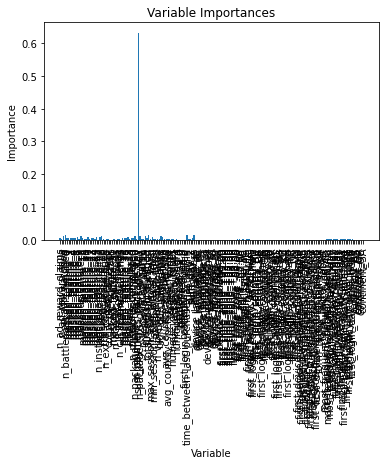

In [57]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');